# RNN - Recurrent Neural Networks
Las Redes Neuronales Recurrentes (RNN) son redes neuronales con memoria. En lugar de tener una entrada y una salida, como una red neuronal normal, las RNN tienen una entrada y una salida, pero también tienen una memoria interna que les permite recordar información sobre lo que han visto hasta ahora. Esto les permite tomar decisiones basadas en lo que han visto hasta ahora. Siempre se utilizan los mismos pesos para cada input, independientemente del número de inputs que se tengan.

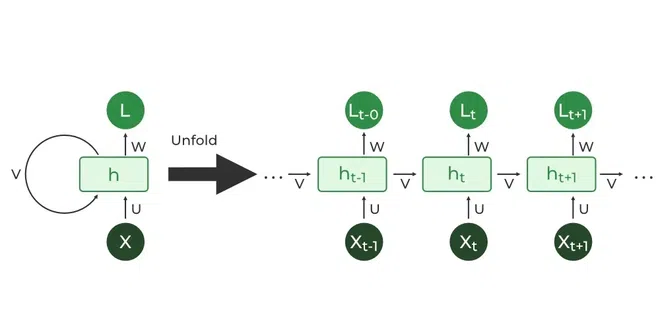

El problema de las RNN es que tienen problemas para recordar información a largo plazo. Esto se debe a que la información se va perdiendo a medida que se avanza en la red (Vanishing Gradient Problem).

In [37]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [38]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

## Cargar los datos y dividirlos en training y validation
Se cargan los datos preprocesados y se dividen en dos conjuntos: training y validation.

In [39]:
df = pd.read_csv('data/goemotions_clean.csv')
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [40]:
# Dividir el dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

## Preprocesamiento de los datos
Para poder utilizar los datos en la red neuronal, es necesario preprocesarlos. El texto debe ser convertido a números, ya que las redes neuronales no pueden trabajar con texto. Para ello, se utiliza la clase Tokenizer de Keras, que convierte el texto a secuencias de números. Además, se añade padding a las secuencias para que todas tengan la misma longitud.

### Tokenizer

In [41]:
# Pasar texto a minúsculas
X_train = X_train.str.lower()
X_val = X_val.str.lower()

In [42]:
## Tokenizar el texto
max_words = 1000 # Número máximo de palabras a considerar en el vocabulario (las más frecuentes), el resto se consideran desconocidas

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)

In [43]:
# Vocabulario
word_index = tokenizer.word_index
print(f'Se encontraron {len(word_index)} tokens únicos.')

Se encontraron 27545 tokens únicos.


In [44]:
# Convertir los textos a secuencias de números
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

In [45]:
# Convertir output a números
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

### Padding

In [46]:
# Comprobar la longitud de las secuencias
max_seq_len = max([len(seq) for seq in train_sequences])
print(f'La secuencia más larga tiene {max_seq_len} tokens.')

La secuencia más larga tiene 18 tokens.


In [47]:
# Padding para que todas las secuencias tengan la misma longitud (agregar ceros al final de la secuencia para ajustarla al tamaño máximo)
X_train_padded = pad_sequences(train_sequences, maxlen=max_seq_len)
X_val_padded = pad_sequences(val_sequences, maxlen=max_seq_len)

In [48]:
# Muestra de algunas secuencias para comprobar que todas tienen la misma longitud
for seq in X_train_padded[:5]:
    print(seq)

[  0   0   0   0   0   0   0   0   0   0   0  29 655  19 140  46 409 256]
[  0   0   0   0   0   0   0 545 663  40  28 180 147 164  31 666 321 522]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  33 683]
[  0   0   0   0   0   0   0   0  49 632   1 807   2  59  35   2  88 960]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  17 120  58]


## Modelo de la red neuronal SimpleRNN
Se crea un modelo de red neuronal SimpleRNN con una capa de embedding, una capa de SimpleRNN y una capa densa de salida. Se compila el modelo y se entrena con los datos de training.

In [49]:
# Número de clases (emociones diferentes)
num_classes = len(df['emotion'].unique())
print(f'Número de clases (emociones): {num_classes}')

Número de clases (emociones): 23


In [50]:
# Definir el modelo
model = Sequential() # Inicializar el modelo
model.add(Embedding(input_dim=max_words, output_dim=32, input_length=max_seq_len)) # Capa de Embedding
model.add(SimpleRNN(32)) # Capa SimpleRNN con 32 unidades (dimensiones)
model.add(Dense(num_classes, activation='softmax')) # Capa de salida con una neurona por cada clase y función de activación softmax para obtener probabilidades

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
## Entrenamiento del modelo
# Definir el tamaño del batch y el número de épocas
batch_size = 128 # número de muestras que se usarán en cada iteración
epochs = 10 # número de iteraciones completas al conjunto de datos de entrenamiento

# Definir callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint('models/rnn.h5', monitor='val_loss', save_best_only=True)]

# Entrenar el modelo
history = model.fit(X_train_padded, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_padded, y_val),
                    callbacks=callbacks)

Epoch 1/10
673/673 [==============================] - 8s 10ms/step - loss: 2.6703 - accuracy: 0.2842 - val_loss: 2.5195 - val_accuracy: 0.3101
Epoch 2/10
 17/673 [..............................] - ETA: 4s - loss: 2.4860 - accuracy: 0.3166

c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


673/673 [==============================] - 6s 8ms/step - loss: 2.4630 - accuracy: 0.3150 - val_loss: 2.4513 - val_accuracy: 0.3156
Epoch 3/10
673/673 [==============================] - 6s 9ms/step - loss: 2.3803 - accuracy: 0.3246 - val_loss: 2.3984 - val_accuracy: 0.3244
Epoch 4/10
673/673 [==============================] - 6s 8ms/step - loss: 2.3402 - accuracy: 0.3298 - val_loss: 2.3825 - val_accuracy: 0.3246
Epoch 5/10
673/673 [==============================] - 6s 9ms/step - loss: 2.3159 - accuracy: 0.3324 - val_loss: 2.3811 - val_accuracy: 0.3266
Epoch 6/10
673/673 [==============================] - 6s 9ms/step - loss: 2.2982 - accuracy: 0.3352 - val_loss: 2.3842 - val_accuracy: 0.3241
Epoch 7/10
673/673 [==============================] - 6s 9ms/step - loss: 2.2815 - accuracy: 0.3358 - val_loss: 2.3886 - val_accuracy: 0.3217
Epoch 8/10
673/673 [==============================] - 6s 9ms/step - loss: 2.2680 - accuracy: 0.3376 - val_loss: 2.3894 - val_accuracy: 0.3224
Epoch 9/10
673/67

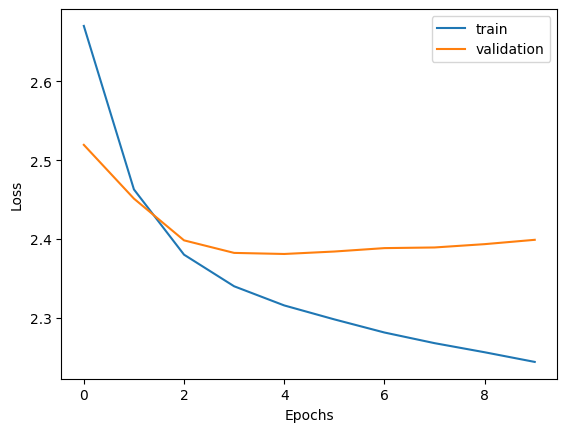

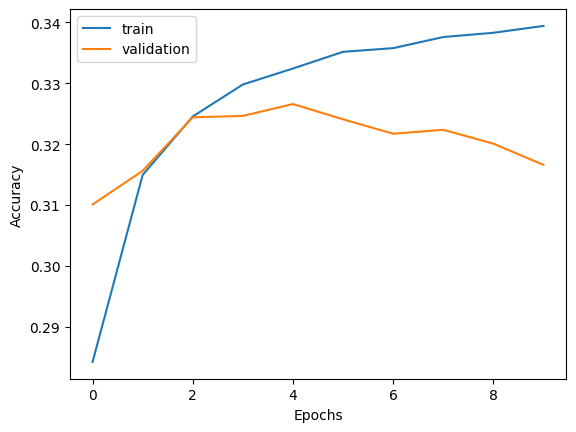

In [52]:
# Mostrar pérdida y precisión en el conjunto de entrenamiento y validación
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Se obtiene una precisión en el conjunto de validación del 32%.

### Predicciones

In [53]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(X_val_padded)

# Obtener las etiquetas originales de las emociones
y_val_labels = label_encoder.inverse_transform(y_val)
emotion_labels = label_encoder.classes_

673/673 [==============================] - 2s 3ms/step


In [54]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [55]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,maybe could put context wa responding someone ...,😐 36%,😑 10%,😕 9%
1,name like picking choosing life work fact work,😐 37%,👍 13%,🤩 8%
2,how people eat paper plate theyre bbq,😐 33%,🤔 12%,😑 12%
3,thank voice reason people keep screaming vatic...,🙏 48%,😐 17%,🥰 9%
4,gotta love trailing minute,❤️ 52%,😐 16%,🤩 6%


## Evaluación del modelo

In [56]:
# Transformar las etiquetas a one-hot encoding para calcular métricas
y_val_onehot = np.zeros((len(y_val), num_classes))
y_val_onehot[np.arange(len(y_val)), y_val] = 1

In [57]:
# Cargar el modelo guardado
model_loaded = load_model('models/rnn.h5')

# Predecir las emociones en el conjunto de validación
y_pred = model_loaded.predict(X_val_padded, verbose=0)

In [58]:
# Evaluar el modelo cargado
column_names = [f'{emotion} {emoji}' for emotion, emoji in emotion_to_emoji.items()]
f1_scores = []
precision_scores = []
threshold = 0
for i in range(0, num_classes):
    emotion_prediction = y_pred[:,i]
    emotion_prediction[emotion_prediction>=threshold]=1
    emotion_prediction[emotion_prediction<threshold]=0
    emotion_test = y_val_onehot[:,i]
    precision = precision_score(emotion_test, emotion_prediction)
    recall = recall_score(emotion_test, emotion_prediction)
    f1 = f1_score(emotion_test, emotion_prediction)
    f1_scores.append(f1)
    precision_scores.append(precision)
    print("Emotion: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(column_names[i], precision, recall, f1))

Emotion: admiration 🤩, Precision: 0.0594, Recall: 1.0000, F1-measure: 0.1122
Emotion: amusement 😄, Precision: 0.0356, Recall: 1.0000, F1-measure: 0.0687
Emotion: anger 😡, Precision: 0.0329, Recall: 1.0000, F1-measure: 0.0637
Emotion: annoyance 😑, Precision: 0.0621, Recall: 1.0000, F1-measure: 0.1169
Emotion: approval 👍, Precision: 0.0793, Recall: 1.0000, F1-measure: 0.1470
Emotion: caring 🥰, Precision: 0.0230, Recall: 1.0000, F1-measure: 0.0450
Emotion: confusion 😕, Precision: 0.0322, Recall: 1.0000, F1-measure: 0.0623
Emotion: curiosity 🤔, Precision: 0.0343, Recall: 1.0000, F1-measure: 0.0664
Emotion: desire 😏, Precision: 0.0149, Recall: 1.0000, F1-measure: 0.0294
Emotion: disappointment 😞, Precision: 0.0349, Recall: 1.0000, F1-measure: 0.0675
Emotion: disapproval 👎, Precision: 0.0549, Recall: 1.0000, F1-measure: 0.1041
Emotion: disgust 🤢, Precision: 0.0228, Recall: 1.0000, F1-measure: 0.0445
Emotion: embarrassment 😳, Precision: 0.0102, Recall: 1.0000, F1-measure: 0.0202
Emotion: exci

c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129392 (\N{SMILING FACE WITH SMILING EYES AND THREE HEARTS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128078

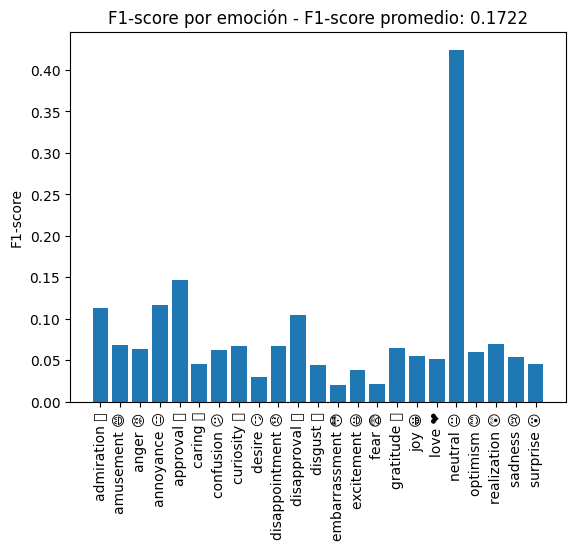

In [59]:
# Gráfico de barras con los F1-scores
fig = plt.figure()
plt.bar(column_names, f1_scores)
plt.xticks(rotation=90)
plt.ylabel('F1-score')
f1_model = f1_score(y_val_onehot, y_pred>threshold, average='weighted') # F1-score ponderado
plt.title('F1-score por emoción - F1-score promedio: {:.4f}'.format(f1_model))
plt.show()

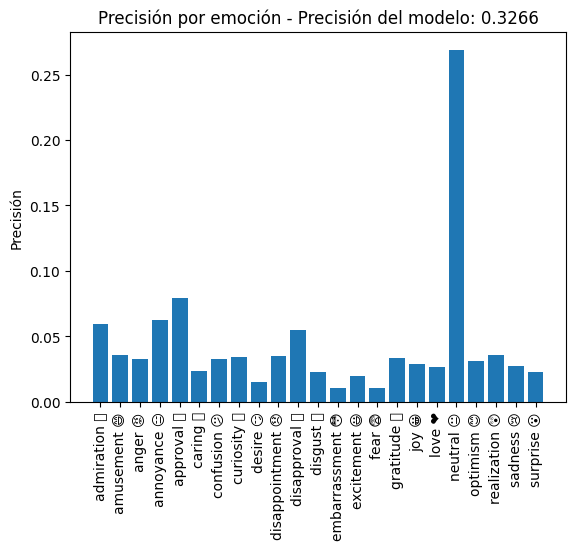

In [60]:
# Graficar precisión por emoción
fig = plt.figure()
plt.bar(column_names, precision_scores)
plt.xticks(rotation=90)
plt.ylabel('Precisión')
_, accuracy = model_loaded.evaluate(X_val_padded, y_val, verbose=0)
plt.title('Precisión por emoción - Precisión del modelo: {:.4f}'.format(accuracy))
plt.show()

El modelo de Red Neuronal Recurrente tiene una **precisión del 33%** en el conjunto de validación y un **F1-Score del 17%**.